In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

This code is correct for atomic units. A good choice of parameters is:
$$T=1.0$$
$$\omega=0.5$$
$$dt=0.2$$

The correctness has also been tested for real units. The following parameter is good enough for kinetic energy estimators, but does not work perfectly for pressure estimators:
$$T=300.0$$
$$\omega=5.0$$
$$dt=0.001$$

For $T=500.0$, the primitive kinetic energy estimator gives the correct result, while the centroid-virial one does not. The reason remains for further investigation.

In [2]:
omega_P

NameError: name 'omega_P' is not defined

In [ ]:
beta

In [549]:
omega**2

1.0

In [603]:
d = 3
P = 4
units = "atomic"
# units = "real"
if units == "atomic":
    kB = 1.0
    hplanck = 1.0
    mvv2e = 1.0
    ftm2v = 1.0
elif units == "real":
    kB = 0.0019872067
    hplanck = 95.306976368
    mvv2e = 48.88821291 * 48.88821291
    ftm2v = 1. / mvv2e
#     mvv2e = 1.0
#     ftm2v = 1.0

L = 10.0
V = L**d
Temp = 1.0
# Temp = 500.0
beta = 1.0 / kB / Temp
hbar = hplanck / 2 / np.pi
omega_P = np.sqrt(P) / (beta * hbar)
m = 1.0
# omega = 5.0
omega = 1.0
dt = 0.2
dtf = dt * ftm2v

prop = np.zeros([2, 2])
prop[0, 0] = np.cos(0.5*dt * omega_P)
prop[1, 1] = np.cos(0.5*dt * omega_P)
prop[0, 1] = np.sin(0.5*dt * omega_P) / omega_P
prop[1, 0] = -np.sin(0.5*dt * omega_P) * omega_P

In [604]:
T = np.zeros([P, P])

def idx(i, P):
    if i<0:
        return i+P
    elif i>=P:
        return i-P
    else:
        return i

for i in range(P):
    T[idx(i, P), idx(i, P)] = 2
    T[idx(i, P), idx(i+1, P)] = -1
    T[idx(i, P), idx(i-1, P)] = -1

In [605]:
def force(x):
#     return -1. * m * omega**2 * (x + x**2 + x**3)
    return -1. * m * omega**2 * x * mvv2e
#     return np.zeros(x.shape[0])

def ke(v):
    ke_val = 0.0
    for i in range(P):
#         print("ke[%d]=%.6e."%(i, 0.5 * Mp[i] * v[i]**2))
        ke_val += 0.5 * Mp[i] * v[i]**2
#     return 0.5 * m * v@v
    return ke_val * mvv2e

def pe(x):
#     return 0.5 / P * m * omega**2 * (x**2 + 2/3*x**3 + 0.5*x**4).sum()
    return 0.5 / P * m * omega**2 * (x**2).sum() * mvv2e
#     return 0

def spring_energy(x):
    return 0.5 * m * omega_P**2 * x@T@x * mvv2e
#     sp_val = 0.0
#     for i in range(P):
#         sp_val += 0.5 * Mp[i] * omega_P**2 * x[i]**2
#     return sp_val

def total_e_pimd(v, x):
    return ke(v) + spring_energy(x) + pe(x)

In [606]:
# Mx2xp = np.zeros([P, P]).astype("complex")
# Mxp2x = np.zeros([P, P])
# for i in range(2, P):
#     for j in range(P):
#         Mx2xp[i, j] = np.sqrt(2) / np.sqrt(P) * np.exp(-2*np.pi*(int(i/2))*j/P*1j)
# #         Mxp2x[i, j] = 1./np.sqrt(P) * np.exp(2*np.pi*j*i/P*1j)
# for i in range(1, P-1):
#     if i%2==1:
#         Mx2xp[i] = Mx2xp[i].real
#     elif i%2==0:
#         Mx2xp[i] = Mx2xp[i].imag
# for j in range(P):
#     Mx2xp[0, j] = 1./np.sqrt(P)
#     Mx2xp[1, j] = 1./np.sqrt(P) * (-1)**j
# Mx2xp = Mx2xp.real
# Mxp2x = Mx2xp.T

In [607]:
Mx2xp = np.zeros([P, P])
Mxp2x = np.zeros([P, P])

for j in range(P):
    Mx2xp[0, j] = 1./np.sqrt(P)
    if P%2==0:
        Mx2xp[P-1, j] = 1./np.sqrt(P) * (-1)**j
    
for i in range(int((P-1)/2)):
    for j in range(P):
        Mx2xp[2*i+1, j] = np.sqrt(2.0) * np.cos ( 2.0 * np.pi * (i+1) * j / P) / np.sqrt(P)
        Mx2xp[2*i+2, j] = -np.sqrt(2.0) * np.sin ( 2.0 * np.pi * (i+1) * j / P) / np.sqrt(P)
        
Mxp2x = Mx2xp.T

In [608]:
def ft(x):
    return Mx2xp @ x
def ift(xp):
    return Mxp2x @ xp
L = Mxp2x.T@T@Mxp2x
L[np.abs(L)<1e-10] = 0
Lam = np.array([L[i, i] for i in range(P)])
Lamp = Lam
Lamp[0] = 1
Mp = m*Lamp

In [609]:
def b_step(v, f):
    return v + 0.5*dtf * f / Mp

def a_step(x, v):
    x[0] += 0.5*dt * v[0]
    for i in range(1, P):
        xv = np.zeros(2)
        xv[0] = x[i]
        xv[1] = v[i]
        xv = prop@xv
        x[i] = xv[0]
        v[i] = xv[1]
    return x, v

In [610]:
gamma_ln = omega_P
c1 = np.exp(-dt * gamma_ln)
c2 = np.sqrt(1.0 - c1**2)

def o_step(v, thermo="PILE_G"):
    eta = np.random.randn(P)
    if thermo=="PILE_G": 
        K = 0.5 * m * v[0]**2 * mvv2e
        alpha2 = c1 + (1. - c1)*eta[0]**2/(2. * beta * K) + 2. * eta[0] * np.sqrt(c1 * (1. - c1) / 2 / beta / K)
        sgn_ = eta[0] + np.sqrt(2*beta*K*c1/(1. - c1))
        sgn = sgn_ / np.abs(sgn_)
        alpha = sgn * np.sqrt(alpha2)
        v[0] *= alpha
    #     print("beta = {:.4f}".format(beta))
        v[1:] = c1 * v[1:] + c2 * np.sqrt(1. / beta / Mp[1:] / mvv2e) * eta[1:]
    elif thermo=="PILE_L":
        v = c1 * v + c2 * np.sqrt(1. / beta / Mp / mvv2e) * eta
    else:
        raise ValueError("Invalid thermostat parameter!")
    return v

In [611]:
# def step(x, v, f):
#     v = b_step(v, f)
#     x = ft(x)
#     x, v = a_step(x, v)
#     v = o_step(v)
#     x, v = a_step(x, v)
#     x = ift(x)
#     f = force(x)
#     f = ft(f)
#     v = b_step(v, f)
#     return x, v, f

In [612]:
def initial_integrate(x, v, f):
    v = b_step(v, f)
    x = ft(x)
    x, v = a_step(x, v)
    return x, v, f
    
def post_integrate(x, v, f):
    v = o_step(v, thermo="PILE_L")
    x, v = a_step(x, v)
    x = ift(x)
    return x, v, f

def post_force(x, v, f):
    se_ = spring_energy(x)
    vir_ = x @ f
    cv_ = x.mean() * f.sum()
    
    t_prim = compute_t_prim(se_)
    t_cv = compute_t_cv(vir_, cv_)
    p_prim = compute_p_prim(se_, vir_)
    p_cv = compute_p_cv(cv_)
    f = 1./P * f
    f = ft(f)
    return x, v, f, t_prim, t_cv, p_prim, p_cv

def final_integrate(x, v, f):
    v = b_step(v, f)
    return x, v, f

In [613]:
def baoab_step(x, v, f):
    x, v, f = initial_integrate(x, v, f)
    x, v, f = post_integrate(x, v, f)
    f = force(x)
    x, v, f, t_prim, t_cv, p_prim, p_cv = post_force(x, v, f)
    x, v, f = final_integrate(x, v, f)
#     print(v[1])
#     print("%.6e, %.6e"%(v[0], x[0]))
#     print(x)
    return x, v, f, t_prim, t_cv, p_prim, p_cv

In [614]:
Nsteps = 1000000

In [616]:
def compute_t_prim(se_):
    return 0.5 * P / beta - se_

def compute_t_cv(vir_, cv_):
    return 0.5 / beta - 0.5 / P * (vir_ - cv_)
#     return -0.5 / P * vir_

def compute_p_prim(se_, vir_):
    return P / beta / V - 2. / d / V  * se_ + 1. / d / V / P * vir_
#     return 0.0

def compute_p_cv(cv_):
    return d / beta / V + 1. / V / P * cv_
#     return 0.0

In [617]:
# x = np.random.randn(P)
x = np.zeros(P)
v = 0.01*np.random.randn(P)
t_prim = 0.0
t_cv = 0.0
p_prim = 0.0
p_cv = 0.0

KE = []
PE = []
SE = []

T_prim = []
T_cv = []
P_prim = []
P_cv = []

for istep in range(Nsteps+1):
    if istep==0:
        f = force(x)
        post_force(x, v, f)
#     print(x[0], v[0], f[0])
    
    if istep%10==0:
        
        KE.append(ke(v))
        PE.append(pe(x))
        SE.append(spring_energy(x))

    if istep%100000==0:
        print("%.6e, %.6e, %.6e"%(ke(v), spring_energy(x), total_e_pimd(v, x)))
#     print()

#     v = b_step(v, f)
#     x = ft(x)
#     x, v = a_step(x, v)
# #     v = o_step(v)
#     x, v = a_step(x, v)
#     x = ift(x)
#     f = force(x)
#     f = ft(f)
#     v = b_step(v, f)
#     print("end of step %d"%istep)
    x, v, f, t_prim, t_cv, p_prim, p_cv = baoab_step(x, v, f)
    T_prim.append(t_prim)
    T_cv.append(t_cv)
    P_prim.append(p_prim)
    P_cv.append(p_cv)
    
KE = np.array(KE)
PE = np.array(PE)
SE = np.array(SE)

T_cv = np.array(T_cv)
P_cv = np.array(P_cv)
T_prim = np.array(T_prim)
P_prim = np.array(P_prim)

9.009493e-05, 0.000000e+00, 9.009493e-05
7.586328e-02, 3.755311e+00, 4.746501e+00
1.148747e+00, 8.711958e-01, 2.173484e+00
2.676307e+00, 1.823491e+00, 4.861078e+00
7.480808e-01, 2.275608e+00, 3.967451e+00
3.242169e+00, 4.756473e+00, 8.019459e+00
5.819434e-01, 1.571182e+00, 3.720932e+00
8.918563e-01, 9.411056e-01, 1.908441e+00
3.241308e+00, 4.088318e+00, 7.712373e+00
3.283639e+00, 2.192523e+00, 5.709517e+00
1.867790e+00, 3.658169e+00, 5.861943e+00


In [552]:
#np.save("lj1_PILEG", np.c_[T_prim, T_cv, P_prim, P_cv])

In [553]:
beta

1.0

In [620]:
t_prim_mean = 3*T_prim[1000:].mean()
t_cv_mean = 3*T_cv[1000:].mean()
p_prim_mean = 3*P_prim[1000:].mean()
p_cv_mean = 3*P_cv[1000:].mean()
print("{:.6f}, {:.6f}, {:.6f}, {:.6f}".format(t_prim_mean, t_cv_mean, p_prim_mean, p_cv_mean))

1.501311, 1.502968, 0.008020, 0.006064


In [3]:
def errbar(data):
    nsamp = 500
    nevery = int(data.shape[0] / nsamp)
    data_ = np.zeros(nsamp)
    for k in range(nsamp):
        data_[k] = data[k*nevery:(k+1)*nevery].mean()
    errbar_ = np.sqrt(data_.var()/(nsamp-1))
    return errbar_

In [622]:
T_prim[1000::100].shape

(9991,)

In [623]:
t_prim_lmp[10::].shape

(9991,)

In [624]:
t_prim_mean = 3*T_prim[1000::100].mean()
t_cv_mean = 3*T_cv[1000::100].mean()
p_prim_mean = 3*P_prim[1000::100].mean()
p_cv_mean = 3*P_cv[1000::100].mean()
print("{:.6f}, {:.6f}, {:.6f}, {:.6f}".format(t_prim_mean, t_cv_mean, p_prim_mean, p_cv_mean))

1.528939, 1.502947, 0.008042, 0.006073


In [625]:
tprimerr = errbar(3*T_prim[1000::100])
tcverr = errbar(3*T_cv[1000::100])
pprimerr = errbar(3*P_prim[1000::100])
pcverr = errbar(3*P_cv[1000::100])

In [4]:
kepr_ = np.load("task3.npy")

In [5]:
t_prim_lmp = kepr_[:, 0]
t_vir_lmp = kepr_[:, 1]
t_cv_lmp = kepr_[:, 2]
p_prim_lmp = kepr_[:, 3]
p_cv_lmp = kepr_[:, 4]
t_prim_lmp_mean = t_prim_lmp[10::].mean()
t_vir_lmp_mean = t_vir_lmp[10::].mean()
t_cv_lmp_mean = t_cv_lmp[10::].mean()
p_prim_lmp_mean = p_prim_lmp[10::].mean()
p_cv_lmp_mean = p_cv_lmp[10::].mean()

In [6]:
tprim_lmperr = errbar(t_prim_lmp[10::])
tvir_lmperr = errbar(t_vir_lmp[10::])
tcv_lmperr = errbar(t_cv_lmp[10::])
pprim_lmperr = errbar(p_prim_lmp[10::])
pcv_lmperr = errbar(p_cv_lmp[10::])

In [7]:
t_vir_lmp_mean

1.5055123363736262

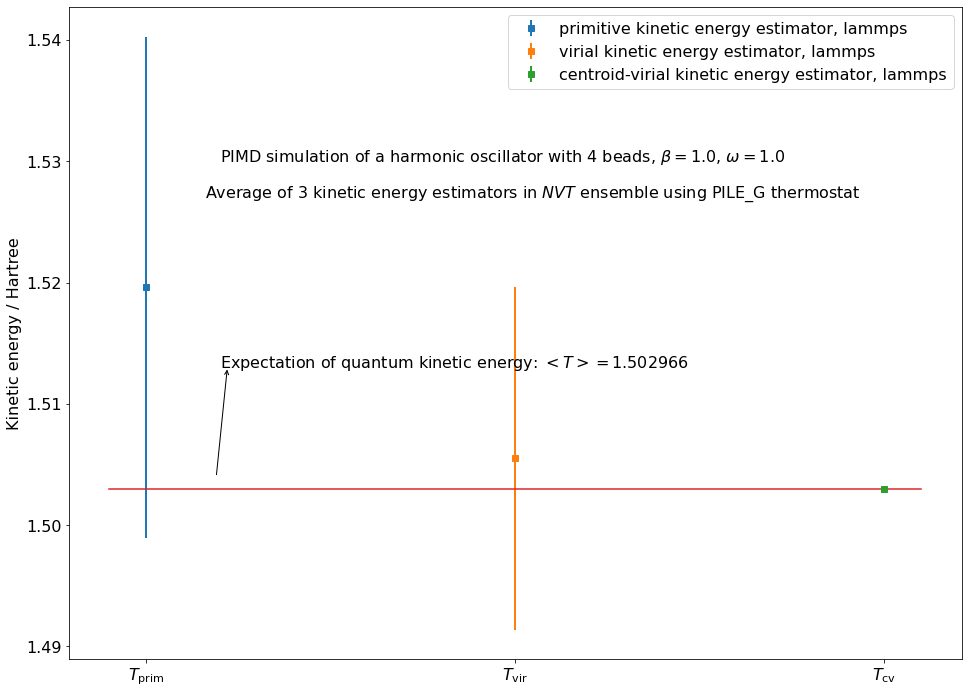

In [13]:
plt.figure(figsize = (16, 12))
plt.xticks([0, 1, 2], ["$T_{\mathrm{prim}}$", "$T_{\mathrm{vir}}$", "$T_{\mathrm{cv}}$"], fontsize = 16)
# plt.xticks([], [], fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel("Kinetic energy / Hartree", fontsize = 16)
# plt.errorbar(0, t_prim_mean, 1.0*tprimerr, marker = "s", linewidth = 0, elinewidth = 2.0, label = "primitive kinetic energy estimator, model code")
# plt.errorbar(1, t_cv_mean, 1.0*tcverr, marker = "s", linewidth = 0, elinewidth = 2.0, label = "centroid-virial kinetic energy estimator, model code")
plt.errorbar(0, t_prim_lmp_mean, 1.0*tprim_lmperr, marker = "s", linewidth = 0, elinewidth = 2.0, label = "primitive kinetic energy estimator, lammps")
plt.errorbar(1, t_vir_lmp_mean, 1.0*tvir_lmperr, marker = "s", linewidth = 0, elinewidth = 2.0, label = "virial kinetic energy estimator, lammps")
plt.errorbar(2, t_cv_lmp_mean, 1.0*tcv_lmperr, marker = "s", linewidth = 0, elinewidth = 2.0, label = "centroid-virial kinetic energy estimator, lammps")
plt.legend(fontsize = 16)
plt.text(0.2, 1.513, "Expectation of quantum kinetic energy: $<T>=1.502966$", fontsize = 16)
plt.text(0.2, 1.53, "PIMD simulation of a harmonic oscillator with 4 beads, $\\beta=1.0$, $\omega=1.0$", fontsize = 16)
plt.text(0.16, 1.527, "Average of 3 kinetic energy estimators in $NVT$ ensemble using PILE$\_$G thermostat", fontsize = 16)
plt.annotate("", xy=(0.19, 1.504), xytext=(0.22, 1.513),arrowprops=dict(arrowstyle="<-"))
plt.plot(np.linspace(-0.1, 2.1, 10), 1.502966*np.ones(10))

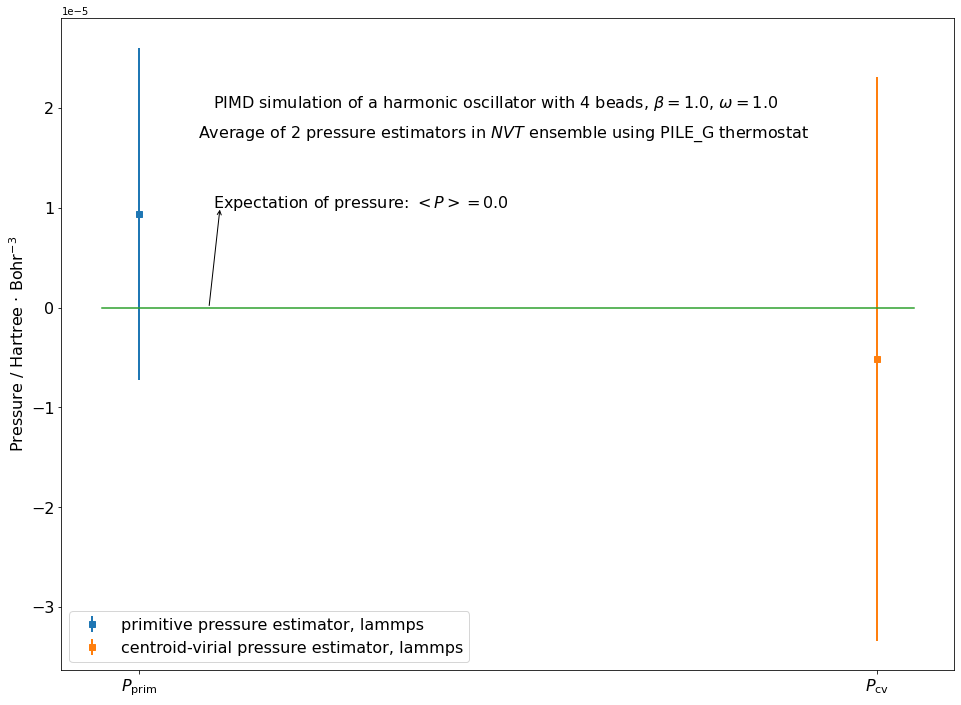

In [15]:
plt.figure(figsize = (16, 12))
plt.xticks([0, 2], ["$P_{\mathrm{prim}}$", "$P_{\mathrm{cv}}$"], fontsize = 16)
# plt.xticks([], [], fontsize = 16)
# plt.ylim(-2e-5, 6e-5)
plt.yticks(fontsize = 16)
plt.ylabel("Pressure / Hartree $\cdot$ Bohr$^{-3}$", fontsize = 16)
# plt.errorbar(0, t_prim_mean, 1.0*tprimerr, marker = "s", linewidth = 0, elinewidth = 2.0, label = "primitive kinetic energy estimator, model code")
# plt.errorbar(1, t_cv_mean, 1.0*tcverr, marker = "s", linewidth = 0, elinewidth = 2.0, label = "centroid-virial kinetic energy estimator, model code")
plt.errorbar(0, p_prim_lmp_mean, 1.0*pprim_lmperr, marker = "s", linewidth = 0, elinewidth = 2.0, label = "primitive pressure estimator, lammps")
plt.errorbar(2, p_cv_lmp_mean, 1.0*pcv_lmperr, marker = "s", linewidth = 0, elinewidth = 2.0, label = "centroid-virial pressure estimator, lammps")
plt.legend(fontsize = 16, loc="lower left")
plt.text(0.2, 1e-5, "Expectation of pressure: $<P>=0.0$", fontsize = 16)
plt.text(0.2, 2e-5, "PIMD simulation of a harmonic oscillator with 4 beads, $\\beta=1.0$, $\omega=1.0$", fontsize = 16)
plt.text(0.16, 1.7e-5, "Average of 2 pressure estimators in $NVT$ ensemble using PILE$\_$G thermostat", fontsize = 16)
plt.annotate("", xy=(0.19, 0), xytext=(0.22, 1e-5),arrowprops=dict(arrowstyle="<-"))
plt.plot(np.linspace(-0.1, 2.1, 10), 0.0*np.ones(10))

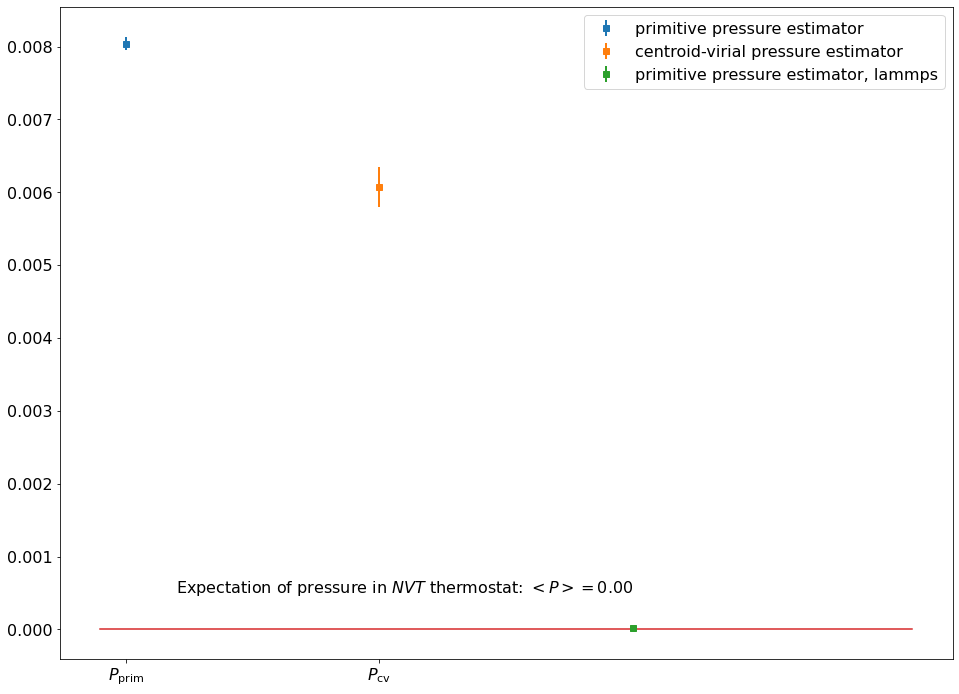

In [627]:
plt.figure(figsize = (16, 12))
plt.xticks([0, 1], ["$P_{\mathrm{prim}}$", "$P_{\mathrm{cv}}$"], fontsize = 16)
plt.yticks(fontsize = 16)
plt.errorbar(0, p_prim_mean, 3.0*pprimerr, marker = "s", linewidth = 0, elinewidth = 2.0, label = "primitive pressure estimator")
plt.errorbar(1, p_cv_mean, 5.0*pcverr, marker = "s", linewidth = 0, elinewidth = 2.0, label = "centroid-virial pressure estimator")
plt.errorbar(2, p_prim_lmp_mean, 1.0*pprim_lmperr, marker = "s", linewidth = 0, elinewidth = 2.0, label = "primitive pressure estimator, lammps")
plt.legend(fontsize = 16)
plt.text(0.2, 0.0005, "Expectation of pressure in $NVT$ thermostat: $<P>=0.00$", fontsize = 16)
# plt.text(0.2, 0.0035, "Harmonic Oscillator, PILE$\_$G thermostat, 4 beads", fontsize = 16)
# plt.text(0.2, 0.003, "Average of 2 pressure estimators", fontsize = 16)
plt.plot(np.linspace(-0.1, 3.1, 10), 0.*np.ones(10))